In [1]:
import os
# WARNING: Execute this cell only once !
os.chdir('../')

In [2]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [3]:
import numpy as np
import torch

/Users/fermanian/.conda/envs/sigenv/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Plots requirements

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

sns.set_style('whitegrid')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

sns.set_palette('colorblind')

color_palette = sns.color_palette("colorblind")

In [5]:
from src.datagen import create_X, get_train_val_test, TumorGrowth
from src.models import SigLasso, GRUModel, NeuralCDE
from src.sampling import downsample
from src.utils import get_cumulative_moving_sum, fill_forward, l2_distance, mse_on_grid, normalize_path
from src.train import train_gru, train_neural_cde

In [6]:
# from experiments.configs import grid_n_points_Y

# Generate and downsample data

In [6]:
model_X = 'cubic'
model_Y = 'cde'

n_points_true = 1000

dim_X = 2
dim_Y = 1
non_linearity_Y = 'Sigmoid'

n_train = n_test = n_val = 50

In [7]:
X_raw_train, Y_raw_train, X_raw_val, Y_raw_val, X_raw_test, Y_raw_test = get_train_val_test(
    model_X,
    model_Y, 
    n_train, 
    n_val, 
    n_test,
    n_points_true,
    dim_X=dim_X, 
    dim_Y=dim_Y,
    non_linearity_Y=non_linearity_Y,
    window_Y = 50
)

In [8]:
print(f'X_raw_train shape: {X_raw_train.shape}, Y_raw_train shape: {Y_raw_train.shape}')

X_raw_train shape: torch.Size([50, 1000, 2]), Y_raw_train shape: torch.Size([50, 1000, 1])


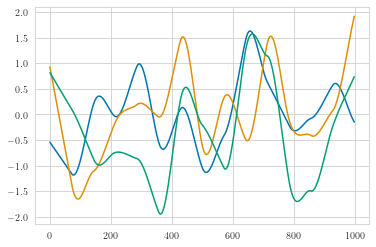

In [9]:
plt.plot(X_raw_train[:3, :, 1].T)
plt.show()

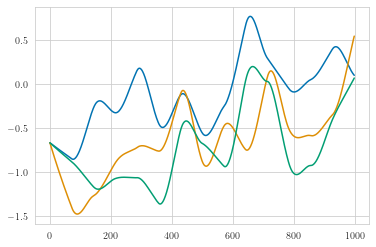

In [10]:
plt.plot(Y_raw_train[:3, :, 0].T)
plt.show()

In [11]:
n_points_Y = 4
n_points_X = 100

In [12]:
X_train, grid_X_train = downsample(
        X_raw_train, n_points_X, keep_first=True, keep_last=True)
Y_train, grid_Y_train = downsample(
        Y_raw_train, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_train)

X_val, grid_X_val = downsample(
        X_raw_val, n_points_X, keep_first=True, keep_last=True)
Y_val, grid_Y_val = downsample(
        Y_raw_val, n_points_Y, keep_first=False, keep_last=True,
        on_grid=grid_X_val)

In [13]:
print(f'X_train shape: {X_train.shape}')
print(f'Y_train shape: {Y_train.shape}')

X_train shape: torch.Size([50, 102, 2])
Y_train shape: torch.Size([50, 5, 1])


# Model 1:  SigLasso

In [14]:
sig_order = 4

lasso_sig = SigLasso(sig_order, Y_train.shape[2], weighted=True, normalize=True)
lasso_sig.train(X_train, Y_train, grid_Y=grid_Y_train, grid_X=grid_X_train)

In [15]:
Y_train_pred = lasso_sig.predict(X_raw_train)
Y_test_pred = lasso_sig.predict(X_raw_test)

In [16]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

print(f'mse_last_point_train = ', mse_on_grid(Y_train_pred, Y_raw_train))
print(f'mse_last_point_val = ', mse_on_grid(Y_test_pred, Y_raw_test))

l2_train =  0.010433753461102693
l2_test =  0.02440085319730425
mse_last_point_train =  0.03687935464738204
mse_last_point_val =  0.14772327812633365


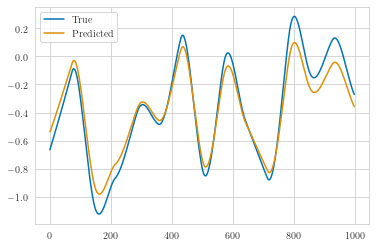

In [17]:
i = 3

plt.plot(np.arange(Y_raw_train.shape[1] ), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

# Model 2 : Neural CDE

In [19]:
n_epochs = 100
ncde_vector_field = 'original'
ncde_lr = 1e-4

ncde_model = NeuralCDE(X_train.shape[2], Y_train.shape[2], vector_field=ncde_vector_field)

train_neural_cde(ncde_model, X_train, Y_train, n_epochs, grid_Y=grid_Y_train, lr=ncde_lr)

Epoch: 0   Training loss: 0.21487699449062347
Epoch: 1   Training loss: 0.20422616600990295
Epoch: 2   Training loss: 0.19615116715431213
Epoch: 3   Training loss: 0.18900196254253387
Epoch: 4   Training loss: 0.1834053248167038
Epoch: 5   Training loss: 0.1791771501302719
Epoch: 6   Training loss: 0.17578090727329254
Epoch: 7   Training loss: 0.17333371937274933
Epoch: 8   Training loss: 0.17167656123638153
Epoch: 9   Training loss: 0.17054380476474762
Epoch: 10   Training loss: 0.16969363391399384
Epoch: 11   Training loss: 0.16913989186286926
Epoch: 12   Training loss: 0.168665811419487
Epoch: 13   Training loss: 0.1682373732328415
Epoch: 14   Training loss: 0.16794580221176147
Epoch: 15   Training loss: 0.16773401200771332
Epoch: 16   Training loss: 0.1675843894481659
Epoch: 17   Training loss: 0.16741631925106049
Epoch: 18   Training loss: 0.16721221804618835
Epoch: 19   Training loss: 0.16701070964336395
Epoch: 20   Training loss: 0.16683432459831238
Epoch: 21   Training loss: 0.

NeuralCDE(
  (initial): Linear(in_features=2, out_features=1, bias=True)
  (func): OriginalVectorField(
    (linear1): Linear(in_features=1, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [20]:
Y_test_pred = ncde_model.predict_trajectory(X_raw_test)
Y_train_pred = ncde_model.predict_trajectory(X_raw_train)

In [21]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

l2_train =  0.0396234
l2_test =  0.04171416


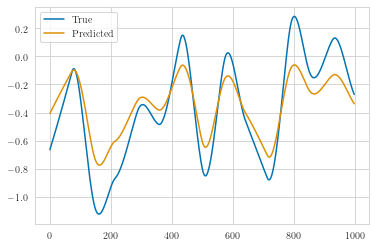

In [22]:
i = 3

plt.plot(np.arange(Y_raw_train.shape[1]), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()

# Model 3 : GRU

In [23]:
gru_hidden_units = 128
gru_lr = 1e-04
n_epochs = 100

gru_model = GRUModel(X_train.shape[2], gru_hidden_units, Y_train.shape[2])

train_gru(gru_model, X_train, Y_train, n_epochs, grid_Y=grid_Y_train, lr=gru_lr)

Epoch: 0   Training loss: 0.23160384595394135
Epoch: 1   Training loss: 0.21782995760440826
Epoch: 2   Training loss: 0.20691727101802826
Epoch: 3   Training loss: 0.19864033162593842
Epoch: 4   Training loss: 0.19270072877407074
Epoch: 5   Training loss: 0.18874987959861755
Epoch: 6   Training loss: 0.18640074133872986
Epoch: 7   Training loss: 0.18524454534053802
Epoch: 8   Training loss: 0.18488851189613342
Epoch: 9   Training loss: 0.1850040853023529
Epoch: 10   Training loss: 0.18535862863063812
Epoch: 11   Training loss: 0.18581345677375793
Epoch: 12   Training loss: 0.18629726767539978
Epoch: 13   Training loss: 0.18677614629268646
Epoch: 14   Training loss: 0.1872333139181137
Epoch: 15   Training loss: 0.1876595914363861
Epoch: 16   Training loss: 0.18804948031902313
Epoch: 17   Training loss: 0.1884000450372696
Epoch: 18   Training loss: 0.1887102723121643
Epoch: 19   Training loss: 0.1889803409576416
Epoch: 20   Training loss: 0.18921136856079102
Epoch: 21   Training loss: 0.

GRUModel(
  (gru): GRU(2, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [24]:
Y_test_pred = gru_model.predict_trajectory(X_raw_test)
Y_train_pred = gru_model.predict_trajectory(X_raw_train)

In [25]:
print(f'l2_train = ', l2_distance(Y_train_pred, Y_raw_train))
print(f'l2_test = ',l2_distance(Y_test_pred, Y_raw_test))

print(f'mse_last_point_train = ', mse_on_grid(Y_train_pred, Y_raw_train))
print(f'mse_last_point_val = ', mse_on_grid(Y_test_pred, Y_raw_test))

l2_train =  0.10697773
l2_test =  0.10746104
mse_last_point_train =  0.27796558
mse_last_point_val =  0.36279887


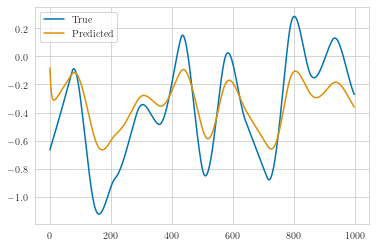

In [27]:
i = 3

plt.plot(np.arange(Y_raw_train.shape[1]), Y_raw_train[i, :, 0], label='True')
plt.plot(np.arange(Y_train_pred.shape[1]), Y_train_pred[i, :, 0], label='Predicted')
plt.legend()
plt.show()